## Visualization of Unemployment Rates Over Time

This plot provides an initial overview of the unemployment trends for **Black or African American** and **Hispanic or Latino** populations over time. Visualizing the raw time series helps identify long-term patterns, seasonal trends, or abrupt changes that may influence the choice of analytical methods.

The graph shows fluctuations in unemployment levels, serving as a baseline for further stationarity checks and causal analysis.


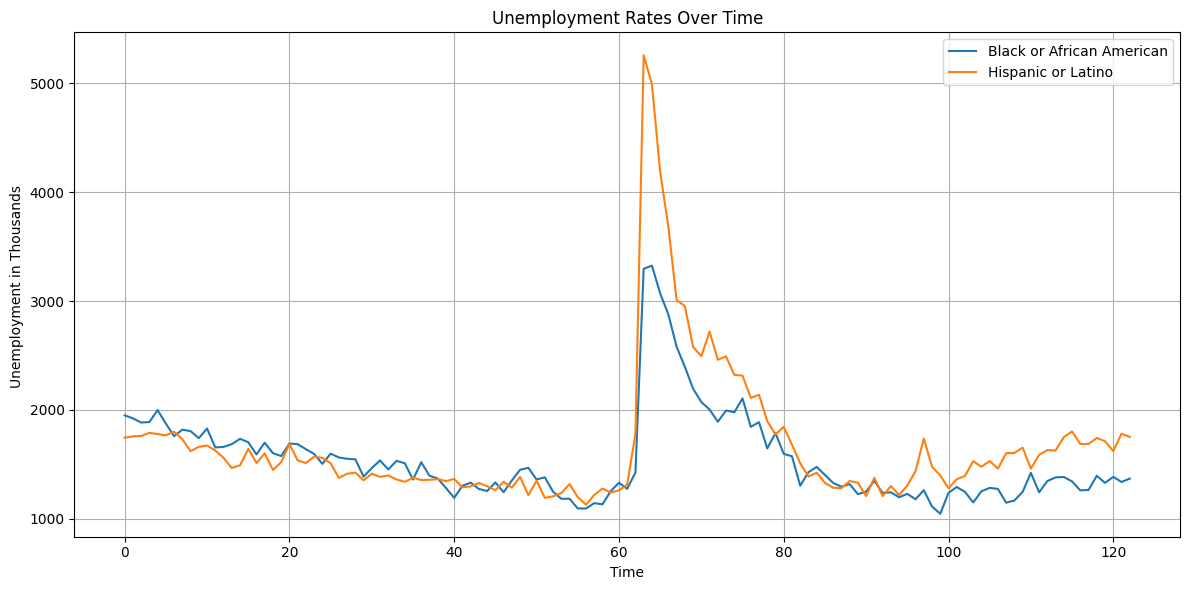

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the Excel file
file_path = 'civilian unemployment.xlsx'
df = pd.read_excel(file_path)

# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Black or African American'], label='Black or African American')
plt.plot(df.index, df['Hispanic or Latino'], label='Hispanic or Latino')
plt.title('Unemployment Rates Over Time')
plt.xlabel('Time')
plt.ylabel('Unemployment in Thousands ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Stationarity Check Using Augmented Dickey-Fuller Test

Before applying time series models, it is essential to determine whether the data is **stationary**, meaning its statistical properties like mean and variance do not change over time. This step uses the **Augmented Dickey-Fuller (ADF) test** to assess stationarity for unemployment rates among:

- **Black or African American**
- **Hispanic or Latino**

If the ADF test returns a **p-value ≤ 0.05**, the null hypothesis of non-stationarity is rejected, indicating the series is likely stationary. Otherwise, differencing or other transformations are needed to stabilize the data.


In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load the Excel file
file_path = 'civilian unemployment.xlsx'  # Update if your path differs
df = pd.read_excel(file_path)

# View first few rows to confirm column names
print(df.columns)

# Optional: set month column as index if needed
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Select the two columns for testing
black_series = df['Black or African American']
hispanic_series = df['Hispanic or Latino']

# Define a function to perform the ADF test and print results
def adf_test(series, name):
    print(f"\nADF Test for {name}")
    result = adfuller(series.dropna())
    print(f"Test Statistic: {result[0]}")
    print(f"P-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    
    if result[1] <= 0.05:
        print("=> The series is likely **stationary** (reject H0)")
    else:
        print("=> The series is likely **non-stationary** (fail to reject H0)")

# Run ADF tests
adf_test(black_series, "Black or African American")
adf_test(hispanic_series, "Hispanic or Latino")


Index(['Month', 'Total', 'Men, 20 years and over', 'Women, 20 years and over',
       'Black or African American', 'Hispanic or Latino'],
      dtype='object')

ADF Test for Black or African American
Test Statistic: -2.803615168389977
P-value: 0.057759219704466055
Critical Value (1%): -3.4851223522012855
Critical Value (5%): -2.88553750045158
Critical Value (10%): -2.5795685622144586
=> The series is likely **non-stationary** (fail to reject H0)

ADF Test for Hispanic or Latino
Test Statistic: -3.568839965947069
P-value: 0.006385456732282176
Critical Value (1%): -3.485585145896754
Critical Value (5%): -2.885738566292665
Critical Value (10%): -2.5796759080663887
=> The series is likely **stationary** (reject H0)


## Granger Causality Analysis of Unemployment Trends Between African American and Hispanic or Latino Populations

This analysis examines the temporal relationship between unemployment rates of African American and Hispanic or Latino populations in the U.S. Using monthly data, we:

1. **Load and preprocess** the unemployment time series data.
2. Apply **first-order differencing** to ensure stationarity.
3. Use a **Vector Autoregression (VAR)** model to select the optimal lag order based on the Akaike Information Criterion (AIC).
4. Perform **Granger Causality Tests** to determine whether changes in one group's unemployment rate can statistically predict changes in the other's.

This helps assess whether economic trends affecting one group may have predictive power over the other’s unemployment patterns.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

# Step 1: Load and prepare the data
file_path = 'civilian unemployment.xlsx'
df = pd.read_excel(file_path)

# Convert Month to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'], format='%b-%y')
df.set_index('Month', inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Step 2: Apply first-order differencing to ensure stationarity
df['Black_diff'] = df['Black or African American'].diff()
df_diff = df[['Black_diff', 'Hispanic or Latino']].dropna()

# Step 3: Fit a VAR model and select optimal lag using AIC/BIC
model = VAR(df_diff)
lag_selection = model.select_order(maxlags=12)

print("\nLag Order Selection Criteria:")
print(lag_selection.summary())

ic_dict = lag_selection.ics  # This contains 'aic', 'bic', etc.

# Step 4: Select optimal lag based on AIC (you may switch to 'bic' if preferred)
aic_values = np.array(ic_dict['aic'][1:])  # Exclude lag 0
best_lag = aic_values.argmin() + 1  # Offset because we skipped lag 0
print(f"\n Optimal lag based on AIC: {best_lag}")

# Step 6: Run Granger Causality test with the selected lag
def run_granger_test(data, col1, col2, max_lag):
    print(f"\nGranger Causality Test: {col1} → {col2} and {col2} → {col1}")
    test_data = data[[col1, col2]].astype(float)
    grangercausalitytests(test_data, maxlag=max_lag, verbose=True)

run_granger_test(df_diff, 'Black_diff', 'Hispanic or Latino', max_lag=best_lag)
run_granger_test(df_diff, 'Hispanic or Latino', 'Black_diff', max_lag=best_lag)


Lag Order Selection Criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        23.63       23.68   1.839e+10       23.65
1        21.06      21.20*   1.394e+09       21.12
2        20.99       21.24   1.306e+09      21.09*
3        21.04       21.38   1.370e+09       21.18
4        20.94       21.38   1.244e+09       21.12
5        20.97       21.51   1.281e+09       21.19
6        21.02       21.65   1.342e+09       21.27
7        21.04       21.78   1.381e+09       21.34
8       20.94*       21.77  1.242e+09*       21.27
9        20.99       21.92   1.313e+09       21.37
10       21.04       22.07   1.390e+09       21.46
11       21.10       22.23   1.478e+09       21.56
12       21.12       22.34   1.507e+09       21.62
--------------------------------------------------

 Optimal lag based on AIC: 8

Granger Causality Test: Black_diff → Hispanic or Latino and Hispanic or

/Users/vishruth/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/vishruth/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/vishruth/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
